## Climate Adaptation Digital Twin: winter temperature in Germany and Heating Degree Days in Darmstadt 

In this tutorial we will use the [`https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr`](https://earthdatahub.destine.eu/collections/d1-climate-dt-ScenarioMIP-SSP3-7.0-IFS-NEMO/datasets/0001-high-sfc) dataset to take a look at the predicted winter temperature in Germany. We will then compute heating degree days for the city of Darmstadt, for the whole dataset duration, and show how fast this process is in Earth Data Hub.

Access to this dataset is restricted to authorized user only via the the Data Cache Management service. First, make sure you have an account on the [Destination Earth platform](https://platform.destine.eu). Then run the following cell, filling in your Destination Earth credentials and password when asked:

In [ ]:
%%capture cap
%run ../cacheb/cacheb-authentication.py

In [ ]:
from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(cap.stdout)

⚠ **NOTE**: the generated password is valid for a limited period of time, and needs to be regenerated and reconfigured periodically by running the cells above.

### Working with EDH data
Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment.

The structure of a workflow that uses EDH data tipically looks like this:

1. data access 
2. data selection
3. (optional) data reduction
4. data download
6. further operations and visualization

[Xarray](https://docs.xarray.dev/en/stable) and [Dask](https://www.dask.org) work together following a lazy principle. This means that when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. 
A smart user will first reduce the amount of data that needs to be downloaded and explicitly call `compute()`
 on it. Once the `compute()`
 operation is complete the data is loaded into memory and available for subsequent fast processing.

#### 1. Data access

In [1]:
import xarray as xr

url = "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr"

ds = xr.open_dataset(
    url, 
    chunks={}, 
    engine="zarr", 
    storage_options={"client_kwargs": {"trust_env": True}}
)
ds

<xarray.Dataset> Size: 188TB
Dimensions:            (time: 175320, latitude: 4096, longitude: 8193)
Coordinates:
  * latitude           (latitude) float64 33kB -90.0 -89.96 ... 89.96 90.0
  * longitude          (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23...
Data variables:
    d2m                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    heightAboveGround  float64 8B ...
    sd                 (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ssr                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    str                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    t2m                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate             (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-06-06T16:50 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

⚠ At this point, no data has been downloaded yet, nor loaded in memory.

#### 2. Data selection

We first select the 2 meters temperature.

In [2]:
xr.set_options(keep_attrs=True)

t2m = ds.t2m
t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"
t2m

<xarray.DataArray 't2m' (time: 175320, latitude: 4096, longitude: 8193)> Size: 24TB
dask.array<sub, shape=(175320, 4096, 8193), dtype=float32, chunksize=(48, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 33kB -90.0 -89.96 -89.91 ... 89.91 89.96 90.0
  * longitude  (longitude) float64 66kB -180.0 -180.0 -179.9 ... 180.0 180.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:00:00
Attributes: (12/19)
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t2m
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    last_restart_dim_updated:        175320
    long_name:                       2 metre temperature
    standard_name:                   air_temperature
    units:                           C

As shown in xarray data representation, the dimension of the `t2m` DataArray is around 20TB. We will now try to narrow down the selection as much as possible.

In [3]:
germany = {'latitude': slice(46, 56), 'longitude': slice(5, 16)}
t2m_germany = t2m.sel(**germany)
t2m_germany_winter = t2m_germany[t2m_germany.time.dt.month.isin([12, 1, 2])]
t2m_germany_winter

<xarray.DataArray 't2m' (time: 43320, latitude: 228, longitude: 251)> Size: 10GB
dask.array<getitem, shape=(43320, 228, 251), dtype=float32, chunksize=(47, 228, 251), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 2kB 46.0 46.04 46.09 ... 55.89 55.93 55.98
  * longitude  (longitude) float64 2kB 5.01 5.054 5.098 ... 15.91 15.95 16.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 347kB 2020-01-01 ... 2039-12-31T23:00:00
Attributes: (12/19)
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t2m
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    last_restart_dim_updated:        175320
    long_name:                       2 metre temperature
    standard_name:                   air_temperature
    units:                           C

In order to estimate the size of the download, we can use the _costing.py_ module:

In [4]:
import costing
costing.estimate_download_size(t2m, t2m_germany_winter)

estimated_needed_chunks: 922
estimated_memory_size: 46.406 GB
estimated_download_size: 4.641 GB


#### 3. Data reduction

We average the 2 metre temperature quarterly, starting on December the 1st. This also is a lazy operation.

In [5]:
%%time

t2m_germany_winter_mean = t2m_germany_winter.resample(time='QS-DEC').mean(dim="time")

CPU times: user 532 ms, sys: 59.5 ms, total: 591 ms
Wall time: 709 ms


#### 4. Data download

This is the phase where we explicitly trigger the download of the data. Remember to assign the return of the `compute()` function to a new variable, so that the data is kept in memory.

In [6]:
t2m_germany_winter_mean_computed = t2m_germany_winter_mean.compute() 

In [7]:
t2m_germany_winter_mean_computed = t2m_germany_winter_mean_computed.dropna("time")

#### 5. Visualization

We will now create and display an animation of the average winter 2 metre temperature in Germany, for the years 2020-2039.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import crs
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=2)
ax.gridlines(draw_labels=True, zorder=3, color="white", alpha=0.5)

t2m_germany_winter_mean_computed.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=True)

# function to update the plot for each frame (each timestep)
def update(frame):    
    data = t2m_germany_winter_mean_computed.isel(time=frame)
    plot = data.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        vmin=-25, 
        vmax=25, 
        add_colorbar=False
    )

    ax.set_title(f"Time: {pd.Timestamp(data['time'].values).strftime('%Y-%m-%d')}") 
    return plot

anim = FuncAnimation(fig, update, frames=len(t2m_germany_winter_mean_computed['time']), repeat=True) # Create the animation
plt.close() # close the static plot to avoid duplicate display
HTML(anim.to_jshtml()) # display the animation in the notebook



### Heating Degree Days (HDD) in Darmstadt

Let us now investigate the Heating Degree Days in Darmstadt. We start again from the 2 metre temperature.

In [10]:
t2m

<xarray.DataArray 't2m' (time: 175320, latitude: 4096, longitude: 8193)> Size: 24TB
dask.array<sub, shape=(175320, 4096, 8193), dtype=float32, chunksize=(48, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 33kB -90.0 -89.96 -89.91 ... 89.91 89.96 90.0
  * longitude  (longitude) float64 66kB -180.0 -180.0 -179.9 ... 180.0 180.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:00:00
Attributes: (12/19)
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t2m
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    last_restart_dim_updated:        175320
    long_name:                       2 metre temperature
    standard_name:                   air_temperature
    units:                           C

We narrow down the selection to the data that is closer to Darmstadt.

In [11]:
darmstadt = {"latitude": 49.88, "longitude": 8.65}
base_temperature = 15 #[°C]

t2m_darmstadt = t2m.sel(darmstadt, method="nearest")
t2m_darmstadt

<xarray.DataArray 't2m' (time: 175320)> Size: 701kB
dask.array<getitem, shape=(175320,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 8B 49.87
    longitude  float64 8B 8.657
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:00:00
Attributes: (12/19)
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t2m
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    last_restart_dim_updated:        175320
    long_name:                       2 metre temperature
    standard_name:                   air_temperature
    units:                           C

We estimate the cost of the download with de `costing`module.

In [12]:
costing.estimate_download_size(t2m, t2m_darmstadt)

estimated_needed_chunks: 3653
estimated_memory_size: 183.862 GB
estimated_download_size: 18.386 GB


We compute the HDD in Darmstadt with a very simplyfied formula:

In [13]:
%%time
t2m_darmstadt_daily_mean = t2m_darmstadt.resample(time='1D').mean(dim='time')
diff = (base_temperature - t2m_darmstadt_daily_mean)
hdd = diff.where(diff > 0).groupby("time.year").sum()

CPU times: user 406 ms, sys: 9.34 ms, total: 415 ms
Wall time: 834 ms


We explicitly trigger the download of the data. Remember to assign the return of the `compute()` function to a new variable, so that the data is kept in memory.

In [14]:
hdd_computed = hdd.compute()

We can finally visualize the HDD in Darmstadt.

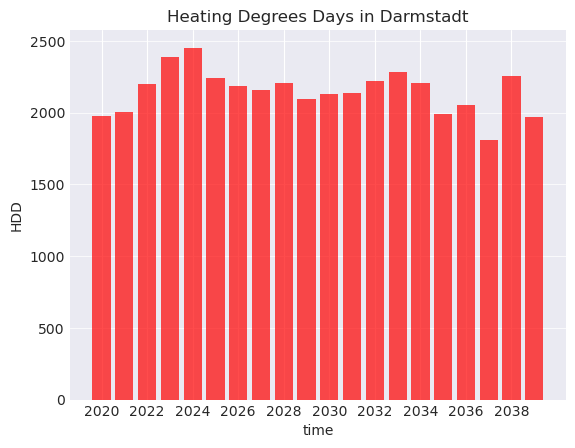

In [15]:
plt.style.use("seaborn-v0_8-darkgrid")

fig, ax = plt.subplots()

plt.bar(hdd_computed.year, hdd.values, color='#ff0000', alpha=0.7)
plt.xlabel('time')
plt.ylabel('HDD')
plt.grid(axis='y', alpha=0.75)
plt.title('Heating Degrees Days in Darmstadt')
plt.xticks(hdd.year[::2]);